# Demonstrate simple MESMER - CLIMADA coupling

## Import a demo exposures of buildings 

In [1]:
from climada.hazard import Hazard
from climada.util.api_client import Client

/home/lpierini/.conda/envs/climada_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
client = Client()

In [3]:
exp = client.get_litpop(country='DEU')

<GeoAxes: title={'center': "LitPop Exposure for ['DEU'] at 150 as, year: 2018, financial mode: pc,\nexp: (1, 1), admin1_calc: False"}>

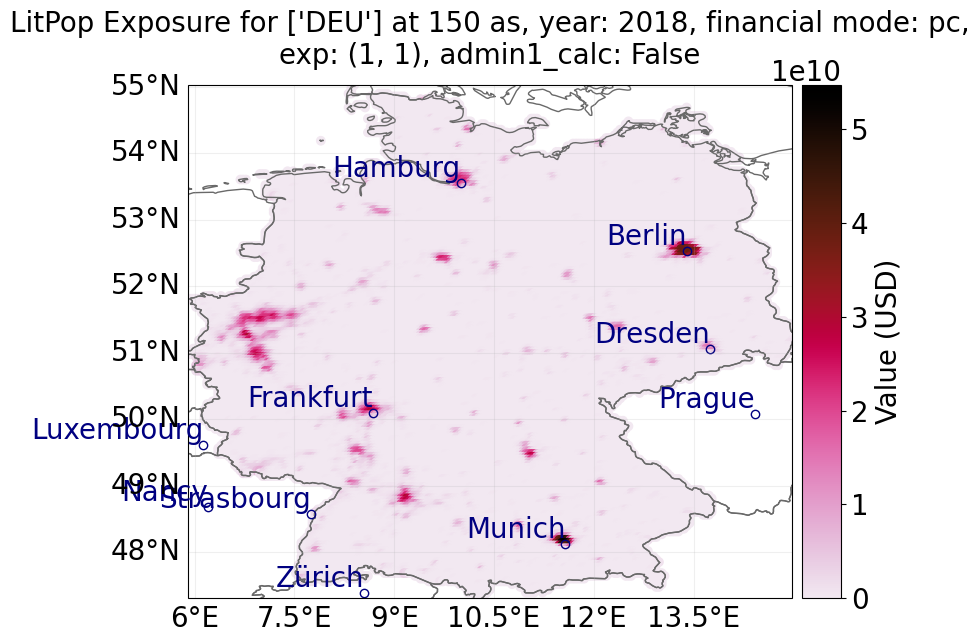

In [4]:
exp.plot_scatter()

## Define impact functions

In [5]:
from climada.entity import ImpactFunc, ImpactFuncSet

In [28]:
impfset = ImpactFuncSet([ImpactFunc.from_step_impf(haz_type='HP', intensity=(0, 50, 200), intensity_unit='mm/day')])

<Axes: title={'center': 'HP 1: '}, xlabel='Intensity (mm/day)', ylabel='Impact (%)'>

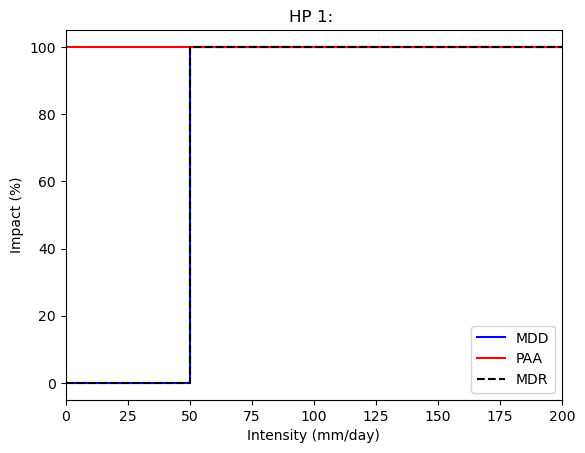

In [29]:
impfset.plot()

## Hazard

In [8]:
from pathlib import Path

In [9]:
DATA = Path('/home/lpierini/Results/mesmer/res/rx1day/emu_CanESM5_200_linloc.nc')

In [39]:
import xarray as xr
xr.open_dataset(DATA)

<xarray.Dataset>
Dimensions:  (lat: 72, lon: 144, time: 251)
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * time     (time) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100
Data variables:
    rx1day   (time, lat, lon) float64 ...
Attributes:
    units:              mm/day
    crs:                EPSG:4326
    coordinate_system:  Geographic
    longitude_units:    degrees_east
    latitude_units:     degrees_north

In [12]:
#Hazard.from_xarray_raster??

In [14]:
haz = Hazard.from_xarray_raster_file(
    #DATA / 'rx1day_ERA5.nc',
    DATA,
    hazard_type='HP',
    intensity_unit='mm/day',
    intensity = 'rx1day',
    coordinate_vars = {'event': 'time', 'longitude':'lon', 'latitude':'lat'},
)

2024-09-26 18:38:48,932 - climada.hazard.base - WARNING - Failed to read values of 'time' as dates. Hazard.event_name will be empty strings


<GeoAxes: title={'center': 'Event ID 221:'}>

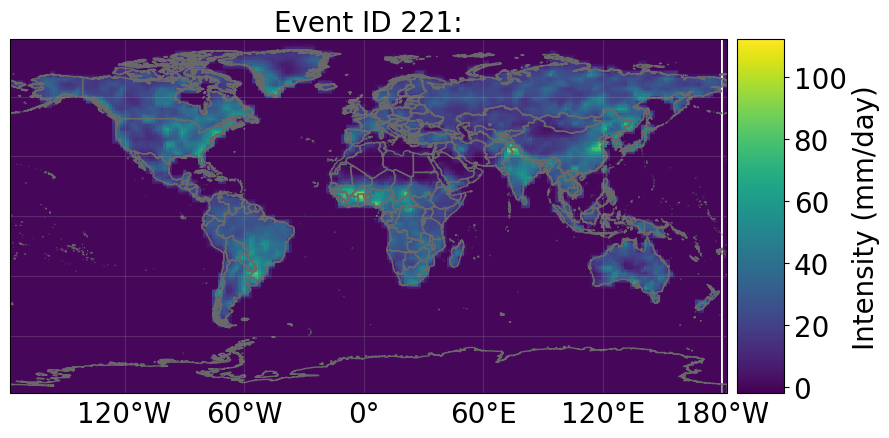

In [47]:
haz.plot_intensity(event=221)

In [17]:
haz.centroids.lon.min()
haz.centroids.lon.max()

178.75

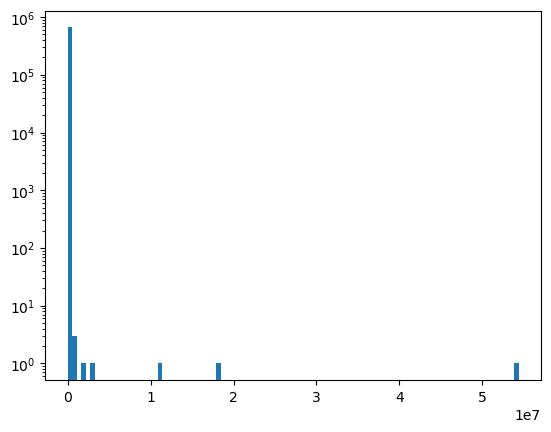

In [18]:
import matplotlib.pyplot as plt
plt.hist(haz.intensity.data, bins=100, log=True);

## Impact Calc

In [19]:
from climada.engine import ImpactCalc

In [43]:
exp.gdf['impf_HP'] = 1

In [44]:
imp = ImpactCalc(exp, impfset, haz).impact()

2024-09-27 10:05:53,102 - climada.util.coordinates - WARNING - Distance to closest centroid is greater than 100km for 15058 coordinates.


<GeoAxes: title={'center': 'Expected annual impact'}>

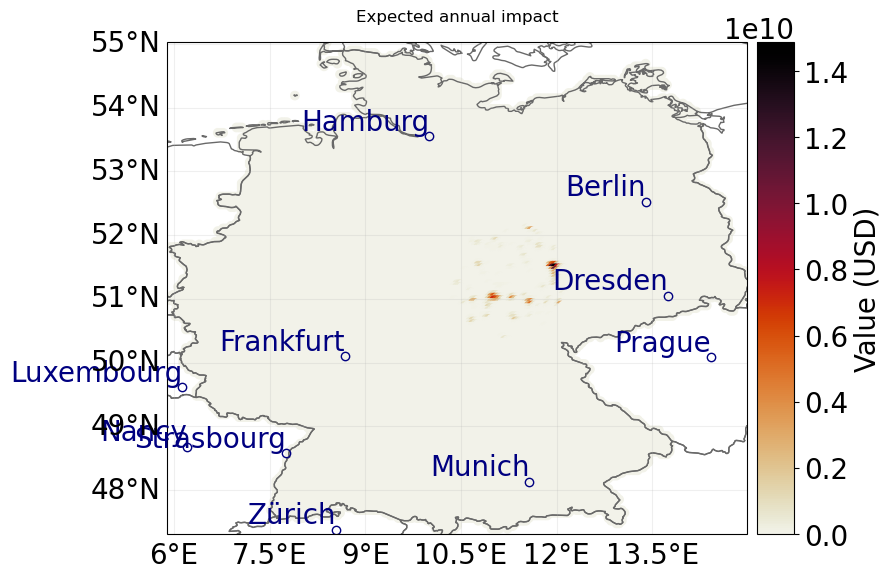

In [45]:
imp.plot_scatter_eai_exposure()